# **1. Czym są modele dyfuzyjne?**

Modele dyfuzyjne (ang. *Diffusion Models*) to klasa **generatywnych modeli probabilistycznych**, które uczą się tworzyć dane (np. obrazy, dźwięki, funkcje matematyczne) przez **stopniowe usuwanie szumu z całkowicie losowego wejścia**.

Proces ten jest odwróceniem kontrolowanego dodawania szumu do rzeczywistego sygnału.

---

## Dwa procesy: **Forward** i **Reverse**

### 1. **Forward process (proces degradacji):**


Zaczynamy od czystych danych (np. obrazek, siatka z wartością funkcji) i **krok po kroku dodajemy szum** aż do uzyskania prawie czystego losowego hałasu. 

&#128898; Matematycznie:  
W kroku $t$ dane stają się:

<div class="alert alert-block alert-info">

$x_t = \sqrt{1 - \beta_t} \cdot x_{t-1} + \sqrt{\beta_t} \cdot \epsilon$

Gdzie:
- $x_t$ – zaszumiona wersja danych,
- $β_t$ – poziom szumu (harmonogram),
- $ε$ – losowy szum (z rozkładu normalnego).
</div>

### 2. **Reverse process (proces odszumiania):**
Teraz uczymy model ($ε_θ$), jak **usunąć szum z $x_t$**, aby odzyskać dane krok po kroku w odwrotnej kolejności.

Model nie przewiduje bezpośrednio danych, tylko **szum, który trzeba usunąć**. Dzięki temu trening jest bardziej stabilny.

---

- Proces forward definiuje znany rozkład $q(x_t | x_{t-1})$, więc możemy go w pełni zasymulować.
- Reverse process $p_\theta(x_{t-1} | x_t) $ jest nieznany - uczymy się go za pomocą sieci neuronowej.
- Uczymy się parametryzacji tego procesu, minimalizując różnicę między rzeczywistym szumem a tym, co przewiduje model:  
  $
  \mathcal{L}_{\text{simple}} = \mathbb{E}_{x, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
  $

To tzw. **simple loss**, używany m.in. w modelu z artykułu  __[Ho et al. (2020).](https://arxiv.org/pdf/2006.11239)__

---

#### Jak to wygląda architektonicznie?

- Najczęściej używa się architektur typu **UNet** – dobrze radzi sobie z wielkoskalowymi danymi i lokalnymi zależnościami.
- Do informacji o czasie $t$ używa się tzw. **sinusoidalnych embeddów czasowych** – to sposób na "zaszycie" liczby (krok czasowy) w wektor przestrzeni, który model może zrozumieć.

#### Jak to działa?

- **Stabilny trening** – brak eksplodujących gradientów jak w GAN-ach
- **Bardzo dobra jakość danych** – najnowsze modele dyfuzyjne generują bardzo realistyczne wyniki
- **Kontrolowalność** – można łatwo sterować stylem, klasą, treścią generowanych danych

# 2. Matematyczne podejście
Modele dyfuzyjne są zbudowane na solidnych podstawach probabilistyki i teorii procesów Markowa.

---

### **1. Proces forward – degradacja sygnału przez szum**
 
Załóżmy, że mamy dane wejściowe $x_0$ (np. obraz, funkcję, cokolwiek). W procesie forward chcemy stopniowo **dodawać szum** w $T$ krokach tak, aby ostatecznie otrzymać czysty biały szum $x_T$.

Modelujemy to jako **proces Markowa**:

<div class="alert alert-block alert-info">

$
q(x_{1:T} | x_0) = \prod_{t=1}^T q(x_t | x_{t-1})
$

</div>

Każdy krok to dodanie trochę szumu:

<div class="alert alert-block alert-info">

$
q(x_t | x_{t-1}) = \mathcal{N}(x_t; \sqrt{1 - \beta_t} x_{t-1}, \beta_t \mathbf{I})
$

Gdzie:
- $ \beta_t \in (0, 1) $ to poziom szumu (np. rośnie liniowo od 0.0001 do 0.02).
- $ \mathbf{I} $ – macierz jednostkowa (czyli izotropiczny szum).
</div>

Ale żeby nie robić tysiąca samplingów, używamy faktu, że można wyrazić dowolny krok wprost względem $ x_0 $:

<div class="alert alert-block alert-info">

$
q(x_t | x_0) = \mathcal{N}(x_t; \sqrt{\bar{\alpha}_t} x_0, (1 - \bar{\alpha}_t) \mathbf{I})
$

Gdzie:
- $ \alpha_t = 1 - \beta_t $
- $ \bar{\alpha}_t = \prod_{s=1}^t \alpha_s $
</div>

To znaczy: **możemy zaszumieć dane od razu do dowolnego kroku $t$** bez symulowania wszystkich poprzednich.

---



### **2. Reverse process – odszumianie**

Tutaj mamy trudniej. Chcemy modelować:

<div class="alert alert-block alert-info">
$
p_\theta(x_{0:T}) = p(x_T) \prod_{t=1}^T p_\theta(x_{t-1} | x_t)
$
</div>

Nie znamy postaci tego rozkładu, więc **uczymy się go** za pomocą sieci neuronowej $ \epsilon_\theta $, która przyjmuje zaszumione dane $ x_t $ i indeks czasu $ t $, i przewiduje szum $ \epsilon $.

Potem rekonstrukcja $ x_{t-1} $ odbywa się jako:

<div class="alert alert-block alert-info">
$
x_{t-1} = \frac{1}{\sqrt{\alpha_t}} \left( x_t - \frac{\beta_t}{\sqrt{1 - \bar{\alpha}_t}} \epsilon_\theta(x_t, t) \right) + \sigma_t z
$

Gdzie:
- $ z \sim \mathcal{N}(0, \mathbf{I}) $ – odrobina losowości (lub deterministycznie dla DDIM)
- $ \sigma_t $ to wariancja – często ustalana heurystycznie
</div>
---

### **3. Funkcja straty**

Używana najczęściej wersja (tzw. *simplified loss*) pochodzi od  __[Ho et al. (2020).](https://arxiv.org/pdf/2006.11239)__:
<div class="alert alert-block alert-info">
$
\mathcal{L}_{\text{simple}} = \mathbb{E}_{x_0, \epsilon, t} \left[ \| \epsilon - \epsilon_\theta(x_t, t) \|^2 \right]
$
</div>

Czyli po prostu **regresja szumu** – model ma nauczyć się przewidywać, jaki szum został dodany do czystego sygnału.

---

# **3. Intuicja na przykładzie sinusoidy**

Załóżmy, że mamy prostą funkcję:
$
x_0(t) = \sin(2\pi t), \quad t \in [0, 1]
$

###  Forward process (szumienie)

W każdym kroku dodajemy odrobinę szumu do wartości sinusoidy.Po kilku krokach wygląda to tak:

| Krok \( t \) | Opis | Wygląd funkcji |
|--------------|------|----------------|
| \( t = 0 \) | Czysta sinusoida | 🟢 Fala sinusoidalna |
| \( t = 100 \) | Lekko zaszumiona | 🔵 Fala z drobnymi zakłóceniami |
| \( t = 500 \) | Prawie nierozpoznawalna | 🔴 Prawie biały szum |
| \( t = 1000 \) | Pełen szum | ⚪️ Biały szum (losowe wartości) |

Zamieniamy porządek w chaos.

---

### Reverse process (odszumianie)

Zaczynamy od białego szumu i **uczymy model, jak stopniowo przywrócić porządek**, krok po kroku rekonstruując czystą sinusoidę.

Na każdym kroku model:
- **bierze zaszumiony sygnał $x_t$**
- **próbuje odgadnąć, jaki szum został dodany**
- **usuwa przewidziany szum**

Efekt końcowy: przy odpowiednio nauczonym modelu, z szumu powstaje sinusoida.

---

####  Porównanie z GAN

| Cecha | GAN | Model dyfuzyjny |
|------|-----|------------------|
| Trening | Adwersarialny (generator vs. dyskryminator) | Regresja szumu |
| Stabilność | Często niestabilny | Bardzo stabilny |
| Jakość wyników | Bardzo dobra, ale może mieć artefakty | Znakomita, fotorealistyczna |
| Kontrola nad generacją | Trudna | Łatwa (np. przez prompty, warunki) |
| Czas generacji | Szybki | Wolniejszy (wiele kroków) |


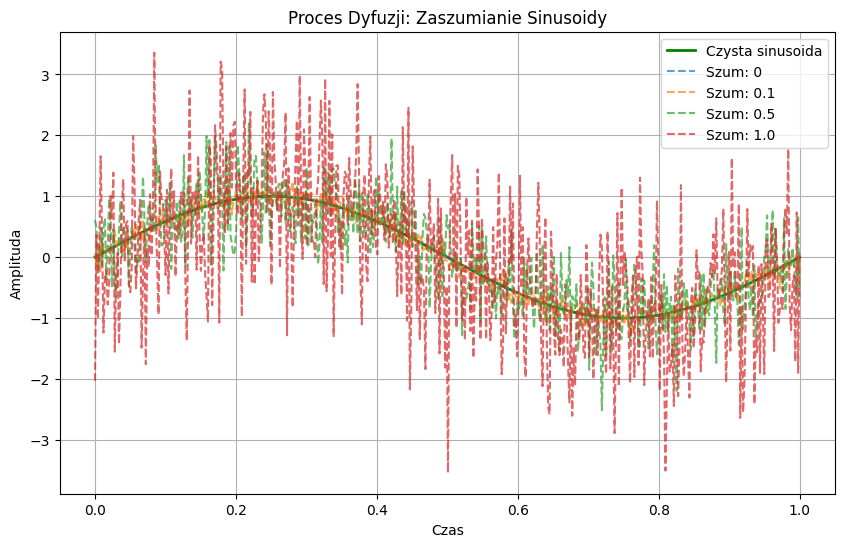

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Parametry
t = np.linspace(0, 1, 500)  # Czas od 0 do 1
sin_wave = np.sin(2 * np.pi * t)  # Czysta sinusoida

# Funkcja dodająca szum
def add_noise(signal, noise_level):
    noise = np.random.normal(0, noise_level, len(signal))
    return signal + noise

# Funkcja tworząca wykres
def plot_diffusion_process(original_signal, noise_levels):
    plt.figure(figsize=(10, 6))

    plt.plot(t, original_signal, label="Czysta sinusoida", color="green", lw=2)
    
    for i, noise_level in enumerate(noise_levels):
        noisy_signal = add_noise(original_signal, noise_level)
        plt.plot(t, noisy_signal, label=f"Szum: {noise_level}", linestyle="--", alpha=0.7)
        

    plt.title("Proces Dyfuzji: Zaszumianie Sinusoidy")
    plt.xlabel("Czas")
    plt.ylabel("Amplituda")
    plt.legend()
    plt.grid(True)
    plt.show()

# Poziomy szumu
noise_levels = [0, 0.1, 0.5, 1.0]

# Wykres
plot_diffusion_process(sin_wave, noise_levels)


# 4. Zastosowania modeli dyfuzyjnych do matematycznych obliczeń

#### 1. **Stabilizacja numeryczna**
W wielu zastosowaniach matematycznych (np. rozwiązywanie równań różniczkowych, układów równań) występują niestabilności numeryczne – małe błędy powodują duże zmiany w wyniku. Modele dyfuzyjne mogą działać jako **filtr stabilizujący**, który:

- rozpoznaje "szum" w danych wyjściowych,
- rekonstruuje bardziej stabilne (czyli gładkie i zgodne z oczekiwaniami) rozwiązanie.

#### 2. **Poprawa przybliżonych obliczeń**
Przykład: mając wynik obliczony metodą przybliżoną (np. metodą Monte Carlo, symulacje), model dyfuzyjny może zostać nauczony, by z tych przybliżeń **odtworzyć dokładniejsze dane** na podstawie wzorców.

#### 3. **Interpolacja i rekonstrukcja danych matematycznych**
- Odtwarzanie brakujących danych w tablicach numerycznych.
- Uzupełnianie fragmentów wykresów funkcji.
- Rekonstrukcja sygnałów w analizie Fouriera czy transformacie falkowej.

#### 4. **Zastosowanie w obrazach matematycznych (np. diagramach, wykresach)**
Dla wykresów z błędami (np. zniekształcony przez skanowanie, szum), model dyfuzyjny może "poprawić" go, przywracając funkcję/obraz do oryginału.

---

Przykładowe kierunki badań:

- **Scientific Machine Learning (SciML)** – łączy modele dyfuzyjne z równościami różniczkowymi.
- **Diffusion priors in inverse problems** – np. w tomografii komputerowej, gdzie model dyfuzyjny odtwarza strukturę obrazu z niepełnych danych.
- **Mathematical Theorem Generation/Proof Correction** – badania nad zastosowaniem modeli generatywnych do poprawy lub tworzenia dowodów matematycznych.

---

## Implementacja dla zaszumionej sinusoidy
Załóżmy, że mamy funkcję `f(x) = sin(x)`, nasze pomiary są zaszumione. Chcemy użyć **miniaturowego modelu dyfuzyjnego**, aby "odszumić" te dane i przywrócić gładką postać funkcji.

---

#### Plan:
1. **Wygenerowanie danych** z funkcji sinus z szumem.
2. **Zbudowanie prostego modelu dyfuzyjnego** w PyTorch.
3. **Wytrenowanie modelu** do odszumiania danych.
4. **Wyniki** na wykresie.

---

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


Microsoft Visual C++ Redistributable is not installed, this may lead to the DLL load failure.
It can be downloaded at https://aka.ms/vs/16/release/vc_redist.x64.exe


OSError: [WinError 126] Nie można odnaleźć określonego modułu. Error loading "C:\Users\klaud\PycharmProjects\pythonProject\.venv\Lib\site-packages\torch\lib\c10.dll" or one of its dependencies.

In [1]:
# 1. Generowanie danych
def generate_data(n_samples=10000):
    x = np.linspace(0.01, np.pi, n_samples)
    y_clean = np.sin(x)
    noise = np.random.normal(0, 0.5, size=x.shape)
    y_noisy = y_clean + noise
    return x, y_clean, y_noisy

In [3]:
# 2. Prosty model "dyfuzyjny" — uczący się denoisingu
class DenoiseNet(nn.Module): # prosta siec neuronowa typu feedforward (MLP) - uczy się mapowania zaszumionych danych wejściowych na ich "czyste" odpowiedniki
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32), #warstwa liniowa, wejście - 1 cecha, wyjście - 32 neurony
            nn.ReLU(), #funkcja aktywacji, dodaje nieliniowość
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.net(x)

NameError: name 'nn' is not defined

In [4]:
# 3. Trening modelu
def train_model(x, y_noisy, y_clean, epochs=1000):
    model = DenoiseNet()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    loss_fn = nn.MSELoss()
    
    x_tensor = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)
    y_noisy_tensor = torch.tensor(y_noisy.reshape(-1, 1), dtype=torch.float32)
    y_clean_tensor = torch.tensor(y_clean.reshape(-1, 1), dtype=torch.float32)

    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(x_tensor)
        loss = loss_fn(outputs, y_clean_tensor)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

    return model

In [16]:
# 4. Wykres wyników
def plot_results(x, y_noisy, y_clean, y_denoised):
    plt.figure(figsize=(10, 5))
    plt.plot(x, y_clean, label='Prawdziwa funkcja sin(x)', color='yellow', linewidth=2)
    plt.scatter(x, y_noisy, label='Zaszumione dane', color='gray', s=10, alpha=0.5)
    plt.plot(x, y_denoised, label='Model odszumiony', color='red')
    plt.legend()
    plt.title("Porównanie danych: prawdziwe vs szum vs model dyfuzyjny")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.grid(True)
    plt.show()

Epoch 0, Loss: 0.563244
Epoch 100, Loss: 0.044174
Epoch 200, Loss: 0.041700
Epoch 300, Loss: 0.036585
Epoch 400, Loss: 0.031552
Epoch 500, Loss: 0.026611
Epoch 600, Loss: 0.024288
Epoch 700, Loss: 0.023310
Epoch 800, Loss: 0.024451
Epoch 900, Loss: 0.022674


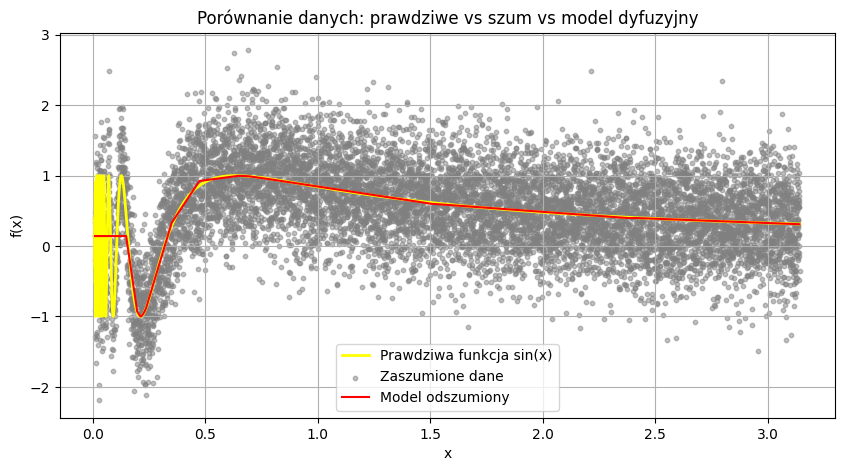

In [19]:
# 5. Główne wykonanie
x, y_clean, y_noisy = generate_data()
model = train_model(x, y_noisy, y_clean)
x_tensor = torch.tensor(x.reshape(-1, 1), dtype=torch.float32)
y_denoised = model(x_tensor).detach().numpy()

plot_results(x, y_noisy, y_clean, y_denoised)

### Wyjaśnienie działania kodu:

- Tworzy dane z szumem (`sin(x) + noise`).
- Uczy małą sieć neuronową na zasadzie **denoising diffusion-lite** (bez pełnego procesu "dyfuzji", ale spełnia analogiczną rolę).
- Po treningu odtwarza funkcję `sin(x)` z zaszumionych danych.

---

## Implementacja dla zaszumionej sinusoidy z wielokrokowym procesem dyfuzyjnym i funkcją 2D
 
Dodajemy do naszych założeń:

- Wielokrokowy proces dyfuzyjny: dodajemy szum do danych w wielu krokach (np. 100), trenujemy model do odwracania szumu krok po kroku (predict noise or denoise).

- Zamienimy dane 1D na funkcję 2D: $f(x, y) = sin(x) * cos(y)$ jako obrazek — symulując np. dane pomiarowe, co pozwali zobaczyć, jak model uczy się odszumiać „powierzchnię”.



In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 1. Funkcja matematyczna 2D
def generate_2d_data(grid_size=64):
    x = np.linspace(0, 2 * np.pi, grid_size)
    y = np.linspace(0, 2 * np.pi, grid_size)
    X, Y = np.meshgrid(x, y)
    Z = np.sin(X) * np.cos(Y)  
    return Z.astype(np.float32)

In [10]:
# 2. Dodawanie szumu (diffusion steps)
def add_noise(x, t, noise):
    return x * torch.sqrt(1 - t) + noise * torch.sqrt(t)

In [11]:
# 3. Prosty model 
class DiffusionNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_input = nn.Conv2d(2, 64, kernel_size=3, padding=1)
        
        # Ścieżka enkodująca
        self.down1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.down2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        
        # Środkowa warstwa
        self.middle = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2)
        )
        
        # Ścieżka dekodująca
        self.up1 = nn.Sequential(
            nn.Conv2d(256 + 256, 128, kernel_size=3, padding=1),  # +256 to skip connection
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2)
        )
        
        self.up2 = nn.Sequential(
            nn.Conv2d(128 + 128, 64, kernel_size=3, padding=1),   # +128 to skip connection
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        # Warstwa wyjściowa
        self.output = nn.Conv2d(64 + 64, 1, kernel_size=3, padding=1)  # +64 to skip connection
    
    def forward(self, x, t_emb):
        # x: [B, 1, H, W], t_emb: [B, 1, H, W]
        x_concat = torch.cat([x, t_emb], dim=1)  # [B, 2, H, W]
        
        # Warstwa wejściowa
        x0 = self.conv_input(x_concat)
        
        # Ścieżka w dół
        x1 = self.down1(x0)
        x2 = self.down2(x1)
        
        # Warstwa środkowa
        x3 = self.middle(x2)
        
        # Ścieżka w górę z skip connections
        x4 = torch.cat([x3, x2], dim=1)
        x4 = self.up1(x4)
        
        x5 = torch.cat([x4, x1], dim=1)
        x5 = self.up2(x5)
        
        x6 = torch.cat([x5, x0], dim=1)
        output = self.output(x6)
        
        return output


In [12]:
# 4. Trening
def train_diffusion(model, clean_data, n_steps=1000, epochs=5000):  # Zwiększona liczba epok
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)  # Zmniejszanie lr
    loss_fn = nn.MSELoss()
    
    # Przekształcenie danych do tensora
    clean_tensor = torch.tensor(clean_data).unsqueeze(0).unsqueeze(0)  # [B, C, H, W]
    
    losses = []
    
    for epoch in range(epochs):
        # Losowy krok czasowy (jako procent szumu)
        t = torch.rand((1, 1, 1, 1))
        
        # Generowanie szumu
        noise = torch.randn_like(clean_tensor)
        
        # Zaszumienie danych
        noised = add_noise(clean_tensor, t, noise)
        
        # Rozszerzenie t do kształtu wejścia
        t_emb = t.expand_as(clean_tensor)
        
        # Przewidywanie szumu przez model
        pred_noise = model(noised, t_emb)
        
        # Obliczenie loss - model uczy się przewidywać szum
        loss = loss_fn(pred_noise, noise)
        
        # Aktualizacja wag
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Aktualizacja lr
        scheduler.step()
        
        losses.append(loss.item())
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")
    
    # Wyświetlenie wykresu loss
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title("Loss podczas treningu")
    plt.xlabel("Epoki")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return model

In [13]:
# 5. Sampling – odszumianie
def sample(model, shape, steps=100):
    # Zaczynamy od szumu
    x = torch.randn(shape)
    
    # Stałe beta dla liniowego harmonogramu
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(beta_start, beta_end, steps)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)
    
    with torch.no_grad():
        for i in reversed(range(steps)):
            t = torch.tensor([i / steps]).reshape(1, 1, 1, 1)
            t_emb = t.expand_as(x)
            
            # Przewidywanie szumu
            pred_noise = model(x, t_emb)
            
            # Stałe dla tego kroku
            alpha = alphas[i]
            alpha_cumprod = alphas_cumprod[i]
            alpha_cumprod_prev = alphas_cumprod[i-1] if i > 0 else torch.tensor(1.0)
            
            # Współczynniki dla algorytmu DDPM
            sigma = 0.0
            if i > 0:
                sigma = torch.sqrt((1.0 - alpha_cumprod_prev) / (1.0 - alpha_cumprod) * (1.0 - alpha_cumprod / alpha_cumprod_prev))
                sigma = torch.clamp(sigma, 0.0, 0.5)  # Stabilizacja
            
            # Odszumianie z ograniczonym dodawaniem szumu
            coef1 = 1.0 / torch.sqrt(alpha)
            coef2 = (1.0 - alpha) / torch.sqrt(1.0 - alpha_cumprod)
            
            # Dodajemy klamry, by uchronić się przed NaN
            coef1 = torch.clamp(coef1, 0.1, 10.0)
            coef2 = torch.clamp(coef2, -10.0, 10.0)
            
            # Nowa wartość x
            x = coef1 * (x - coef2 * pred_noise)
            
            # Dodajemy minimalne sigma tylko w krokach pośrednich
            if i > 0:
                x = x + sigma * torch.randn_like(x)
            
            # Klampowanie wartości x, aby zapobiec wybuchom liczbowym
            x = torch.clamp(x, -5.0, 5.0)
            
            # Debug co 10 kroków
            if i % 10 == 0:
                print(f"Krok {steps-i}: min: {x.min().item():.4f}, max: {x.max().item():.4f}, mean: {x.mean().item():.4f}")
    # Na końcu funkcji sample
    print("Końcowe statystyki odszumionego tensora:")
    print(f"- Shape: {x.shape}")
    print(f"- Type: {x.dtype}")
    print(f"- Contains NaN: {torch.isnan(x).any().item()}")
    print(f"- Contains Inf: {torch.isinf(x).any().item()}")
    print(f"- Min: {x.min().item():.6f}")
    print(f"- Max: {x.max().item():.6f}")
    print(f"- Mean: {x.mean().item():.6f}")
    print(f"- Std: {x.std().item():.6f}")
    
    # Jeśli wykryto NaN lub Inf, napraw je:
    if torch.isnan(x).any() or torch.isinf(x).any():
        print("Wykryto NaN lub Inf, naprawianie...")
        x = torch.nan_to_num(x, nan=0.0, posinf=1.0, neginf=-1.0)
        print(f"Po naprawie - min: {x.min().item():.6f}, max: {x.max().item():.6f}")
    
    return x


Generowanie danych...
Dane wejściowe - min: -0.9997, max: 0.9997, mean: -0.0000
Inicjalizacja modelu...
Rozpoczęcie treningu na 2000 epokach...
Epoch 0, Loss: 1.195197
Epoch 500, Loss: 0.015250
Epoch 1000, Loss: 0.010358
Epoch 1500, Loss: 0.008440


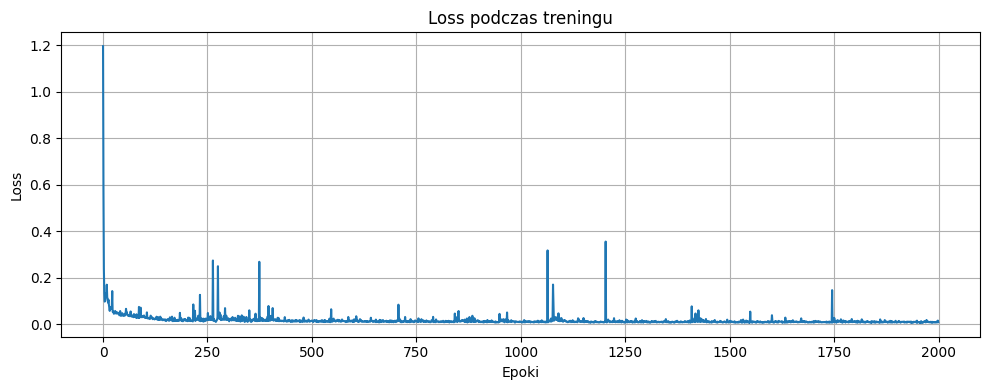


 Odszumianie - generowanie obrazu...
Krok 10: min: -3.6972, max: 3.2300, mean: 0.0054
Krok 20: min: -3.5240, max: 2.9435, mean: 0.0045
Krok 30: min: -3.0512, max: 3.1461, mean: 0.0098
Krok 40: min: -2.6867, max: 2.6567, mean: 0.0060
Krok 50: min: -2.2360, max: 2.2846, mean: 0.0085
Krok 60: min: -1.6201, max: 1.7082, mean: 0.0070
Krok 70: min: -1.3767, max: 1.3972, mean: 0.0003
Krok 80: min: -1.1211, max: 1.1167, mean: -0.0029
Krok 90: min: -0.6190, max: 0.6009, mean: -0.0006
Krok 100: min: -0.3817, max: 0.3472, mean: -0.0010
Końcowe statystyki odszumionego tensora:
- Shape: torch.Size([1, 1, 64, 64])
- Type: torch.float32
- Contains NaN: False
- Contains Inf: False
- Min: -0.381682
- Max: 0.347218
- Mean: -0.001022
- Std: 0.133681
Wygenerowany obraz - min: -0.3817, max: 0.3472, mean: -0.0010


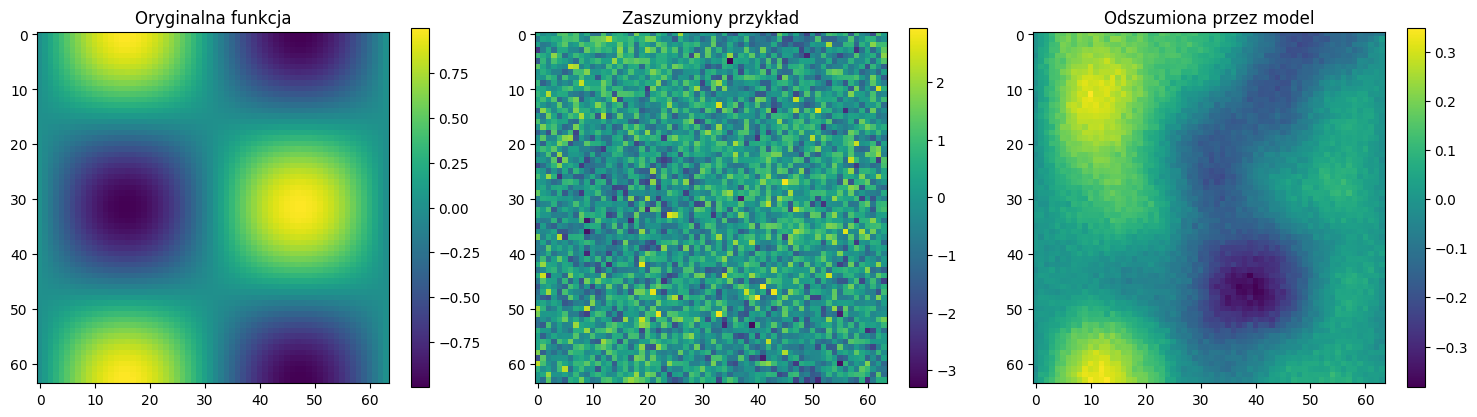

In [14]:
# 6. Uruchomienie i wizualizacja
def run_diffusion_model(grid_size=64, training_epochs=5000):
    print("Generowanie danych...")
    clean = generate_2d_data(grid_size)

    print(f"Dane wejściowe - min: {clean.min():.4f}, max: {clean.max():.4f}, mean: {clean.mean():.4f}")

    print("Inicjalizacja modelu...")
    model = DiffusionNet()

    print(f"Rozpoczęcie treningu na {training_epochs} epokach...")
    trained_model = train_diffusion(model, clean, epochs=training_epochs)

    print("\n Odszumianie - generowanie obrazu...")
    denoised = sample(trained_model, shape=(1, 1, grid_size, grid_size), steps=100)
    denoised_np = denoised.squeeze().detach().numpy()

    print(
        f"Wygenerowany obraz - min: {denoised_np.min():.4f}, max: {denoised_np.max():.4f}, mean: {denoised_np.mean():.4f}")

    # Wizualizacja
    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.title("Oryginalna funkcja")
    plt.imshow(clean, cmap='viridis')
    plt.colorbar()

    plt.subplot(1, 3, 2)
    plt.title("Zaszumiony przykład")
    noisy_example = add_noise(torch.tensor(clean).unsqueeze(0).unsqueeze(0),
                              torch.tensor(0.8),
                              torch.randn(1, 1, grid_size, grid_size))
    plt.imshow(noisy_example.squeeze().numpy(), cmap='viridis')
    plt.colorbar()

    plt.subplot(1, 3, 3)
    plt.title("Odszumiona przez model")
    plt.imshow(denoised_np, cmap='viridis')
    plt.colorbar()

    plt.tight_layout()
    plt.show()

    return trained_model, denoised_np


# Uruchomienie z mniejszą liczbą epok dla szybkiego testowania
trained_model, result = run_diffusion_model(training_epochs=2000)


### Wyjaśnienie działania kodu:

- Model uczy się przewidywać szum dodany do danych w losowych krokach (jak w realnych diffusion models).
- Po treningu możemy go wykorzystać do rekonstrukcji danych z zaszumionych wejść.